# Atividade 1 : previsão de séries temporais

- Objeto de estudo: contratos futuros de commodities agrícolas
- Série escolhida: preço do milho futuro negociado na CBOT  


## Relatório Empírico

- Objeto de estudo: contratos futuros de commodities agrícolas
- Série escolhida: preço do milho futuro negociado na CBOT 
- Importancia: 
    - Brasil exportador de commodities 
    - Preços de commodities possuem grande impacto na economia Brasileira e global  (contexto inflacionário)
    - Apesar da série não ser de negociações na B3, os EUA abrigam o maior mercado financeiro do Mundo.
- Justficativas metodológicas :
    - Divisão de treino e teste
    - ARIMA 
    - Rede Neural
    - XGBoost



In [1]:
%load_ext autoreload
%autoreload 2

import ta
import datetime
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import pmdarima as pm
import xgboost as xgb
import plotly.express as px
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV ,TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error






# codigos adaptados do livro Modern Time Series Forecasting with Python
from stationary_checks import  (check_heteroscedastisticity, check_seasonality, check_trend,check_unit_root)
from transformations import AutoStationaryTransformer 

#codigos prorpios
#from modeling_utils import train_test_split, get_kpis_summary ,check_arima_residuals , plot_acf_pcf
from modeling_utils import * 

warnings.filterwarnings("ignore")
get_ipython().run_line_magic("matplotlib", "inline")


## 1. Dados

[*DESCREVER*]

In [2]:


plt.style.use("fivethirtyeight")
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

# Carrega a base
ticker = "ZC=F"
commodity = yf.download(ticker, "2002-01-01", "2023-05-01")
#commodity = yf.download(ticker, "2002-01-01", "2023-04-30",interval='1mo')


[*********************100%***********************]  1 of 1 completed


In [3]:
commodity.to_csv("ZCF-CBOT.csv")

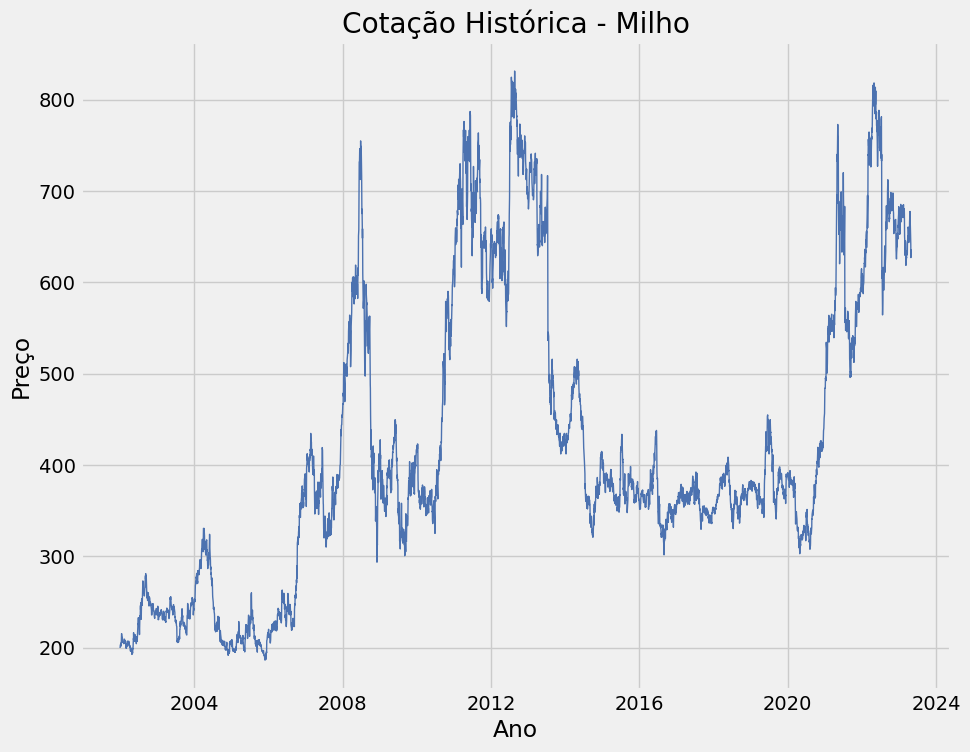

In [4]:

with plt.style.context("seaborn-deep"):
    plt.figure(figsize = (10,8))
    plt.plot(commodity["Adj Close"], linewidth = 1)
    plt.xlabel("Ano")
    plt.ylabel("Preço")
    plt.title("Cotação Histórica - Milho")

<AxesSubplot:xlabel='Date'>

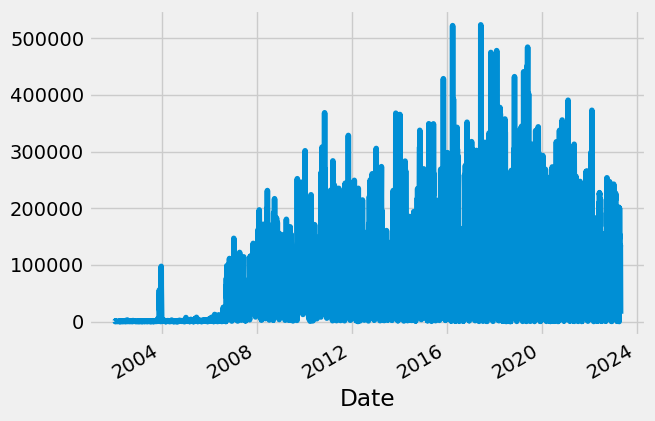

In [5]:
# Baixo volume no inicio da serie - aumento apenas em 2008
# estartegias nesse periodo seriam dificeis de serem implatadas 

commodity['Volume'].plot() 

In [6]:
commodity['return'] = commodity['Adj Close'].pct_change()
commodity.dropna(inplace=True)
commodity # dados OHLC

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2002-01-03,202.00,202.00,202.00,202.00,202.00,4,0.012531
2002-01-04,202.50,202.50,202.50,202.50,202.50,4,0.002475
2002-01-07,203.50,203.50,203.50,203.50,203.50,4,0.004938
2002-01-08,204.00,204.00,204.00,204.00,204.00,4,0.002457
2002-01-09,202.50,202.50,202.50,202.50,202.50,4,-0.007353
...,...,...,...,...,...,...,...
2023-04-24,663.25,667.50,648.50,651.25,651.25,134977,-0.018093
2023-04-25,651.25,653.00,641.50,646.50,646.50,100633,-0.007294
2023-04-26,648.00,652.25,641.00,641.50,641.50,65293,-0.007734


In [7]:
commodity.describe()

,Open,High,Low,Close,Adj Close,Volume,return
count,5366.000000,5366.000000,5366.000000,5366.000000,5366.000000,5366.000000,5366.000000
mean,419.511135,424.426482,414.891493,419.615123,419.615123,90848.904025,0.000384
std,161.074133,163.863489,158.268865,161.081246,161.081246,83860.066278,0.018268
min,186.250000,187.000000,185.750000,186.250000,186.250000,0.000000,-0.235567
25%,325.000000,328.812500,321.250000,325.000000,325.000000,2493.000000,-0.009379
50%,374.000000,378.250000,370.125000,374.250000,374.250000,89314.500000,0.000000
75%,539.937500,547.937500,531.500000,539.187500,539.187500,147422.250000,0.009894
max,830.250000,843.750000,822.750000,831.250000,831.250000,523849.000000,0.136066


In [8]:
commodity.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
return       0
dtype: int64

# Metodologia


## Checks de propriedades estatísticas

### Preços mensais

In [13]:
month_commodity = commodity.copy().asfreq("M",method='ffill')

In [14]:
checks_stats(month_commodity['Adj Close'])

Unit root test:  
 
 ADF_Test(stationary=False, results=(-1.591899912578697, 0.48766117879405096, 13, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, 2478.3119123902893)) 
 
 --------------------------------------------------
Trend Test: 
 
 Kendall_Tau_Test(trend=True, direction='increasing', slope=0.36080822474529417, p_value=9.53952432839236e-18, deterministic=False, deterministic_trend_results=ADF_deterministic_Trend_Test(deterministic_trend=False, adf_res=ADF_Test(stationary=False, results=(-1.591899912578697, 0.48766117879405096, 13, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, 2478.3119123902893)), adf_ct_res=ADF_Test(stationary=False, results=(-1.8484954892154453, 0.6809182353553195, 13, 241, {'1%': -3.9968337688702165, '5%': -3.4288662447936313, '10%': -3.1378478075975025}, 2479.4108135661213)))) 
 
 --------------------------------------------------
Seasonality Test:  
 
 Seasonality_Test(seasona

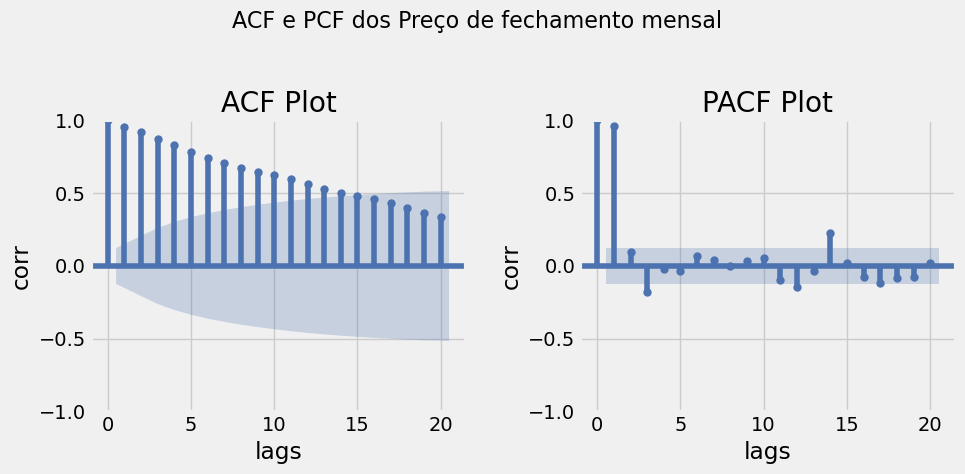

In [15]:
plot_acf_pcf(month_commodity['Adj Close'],fig_title="ACF e PCF dos Preço de fechamento mensal")

### Retornos mensais

In [16]:
checks_stats(month_commodity['Adj Close'].pct_change().dropna())

Unit root test:  
 
 ADF_Test(stationary=True, results=(-9.75169046640416, 7.984409372936552e-17, 1, 252, {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}, -469.5222329307303)) 
 
 --------------------------------------------------
Trend Test: 
 
 Kendall_Tau_Test(trend=False, direction='increasing', slope=3.1122591889452555e-05, p_value=0.9994104230812488, deterministic=False, deterministic_trend_results=ADF_deterministic_Trend_Test(deterministic_trend=False, adf_res=ADF_Test(stationary=True, results=(-9.75169046640416, 7.984409372936552e-17, 1, 252, {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}, -469.5222329307303)), adf_ct_res=ADF_Test(stationary=True, results=(-9.734545051890295, 8.546493724188268e-15, 1, 252, {'1%': -3.9951510399519887, '5%': -3.4280573478136107, '10%': -3.1373735230776614}, -467.5618531110299)))) 
 
 --------------------------------------------------
Seasonality Test:  
 
 Seasonality_Test(sea

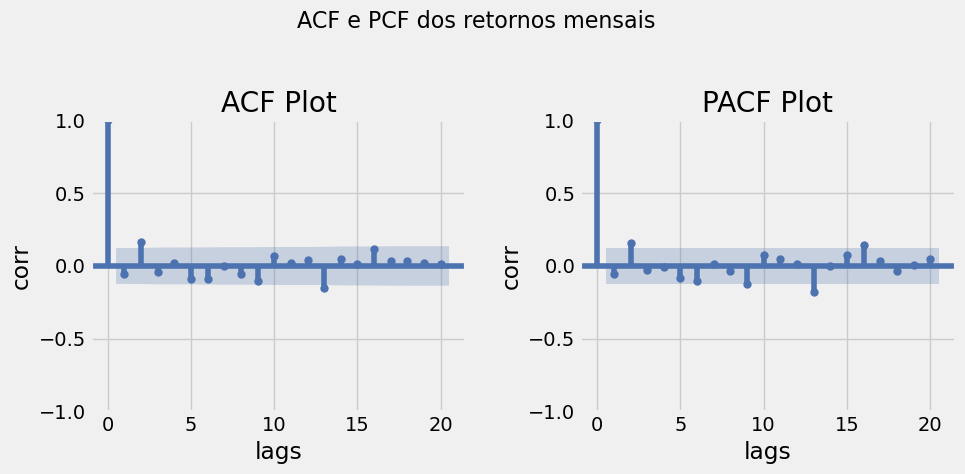

In [17]:
plot_acf_pcf(month_commodity['Adj Close'].pct_change().dropna(),fig_title="ACF e PCF dos retornos mensais")

## Modelos ARIMA


In [26]:
#month_commodity = commodity.copy().set_index("Date").asfreq("M",method='ffill')
month_commodity = month_commodity.reset_index()
month_commodity = month_commodity[['Date',"Adj Close"]]

train_commodity_monthly ,test_commodity_monthly  = train_test_split(month_commodity,date_column='Date',split='2022-01-01',by_date=True)

train_price_monthly = train_commodity_monthly.dropna()["Adj Close"]
test_price_monthly = test_commodity_monthly.dropna()["Adj Close"]

print("Tamanho treino: ",len(train_price_monthly))
print("Tamanho teste: ",len(test_price_monthly))


auto_stationary = AutoStationaryTransformer()
train_price_monthly_transformed =  auto_stationary.fit_transform(train_price_monthly, freq="1M")


Train : start:2002-01-31 00:00:00 ---- end:2021-12-31 00:00:00
Test : start:2022-01-31 00:00:00 ---- end:2023-03-31 00:00:00
Tamanho treino:  240
Tamanho teste:  15
(0, 1, 1)


### Arima Expanding Window (Mensal)

In [34]:
exp_arima_v1 = get_expanding_arima(train_price_monthly,test_price_monthly,print_flags=True)

2022-01-31 00:00:00 forecasted !!!!
Prediction:  590.9002331303011
---------------
2022-02-28 00:00:00 forecasted !!!!
Prediction:  624.9485348310743
---------------
2022-03-31 00:00:00 forecasted !!!!
Prediction:  694.6884171929491
---------------
2022-04-30 00:00:00 forecasted !!!!
Prediction:  753.8846181179065
---------------
2022-05-31 00:00:00 forecasted !!!!
Prediction:  820.4299180900404
---------------
2022-06-30 00:00:00 forecasted !!!!
Prediction:  769.6074511778683
---------------
2022-07-31 00:00:00 forecasted !!!!
Prediction:  735.4413957056569
---------------
2022-08-31 00:00:00 forecasted !!!!
Prediction:  637.4328119046893
---------------
2022-09-30 00:00:00 forecasted !!!!
Prediction:  650.2903138475135
---------------
2022-10-31 00:00:00 forecasted !!!!
Prediction:  697.6499180333286
---------------
2022-11-30 00:00:00 forecasted !!!!
Prediction:  672.6965586870934
---------------
2022-12-31 00:00:00 forecasted !!!!
Prediction:  680.9065969764185
---------------
2023

In [35]:
comparative_v3 = test_price_monthly.reset_index().rename(columns={"Adj Close":"True_values"})
comparative_v3['ARIMA_V3'] = exp_arima_v1['expand_forecasts']['Expanding_ARIMA_pred']
comparative_v3['Naive_last_value'] = comparative_v3['True_values'].shift(1)
comparative_v3

,Date,True_values,ARIMA_V3,Naive_last_value
0,2022-01-31,626.00,590.900233,NaN
1,2022-02-28,697.50,624.948535,626.00
2,2022-03-31,748.75,694.688417,697.50
3,2022-04-30,818.25,753.884618,748.75
4,2022-05-31,753.50,820.429918,818.25
5,2022-06-30,743.75,769.607451,753.50
6,2022-07-31,616.25,735.441396,743.75
7,2022-08-31,673.75,637.432812,616.25
8,2022-09-30,677.50,650.290314,673.75
9,2022-10-31,691.50,697.649918,677.50


<AxesSubplot:xlabel='Date'>

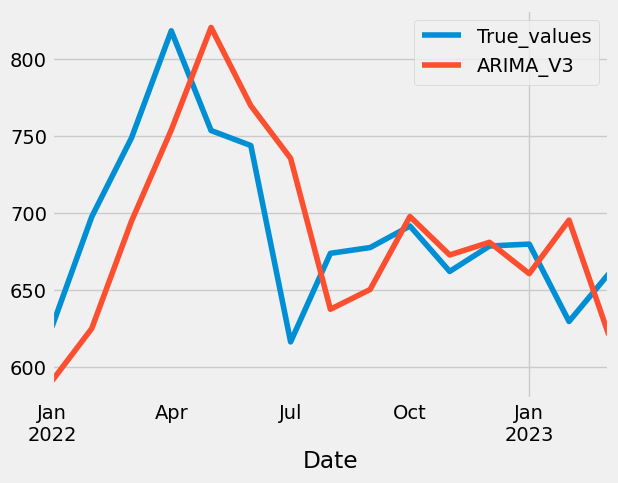

In [36]:
comparative_v3.set_index("Date")[['True_values',"ARIMA_V3"]].plot()

<AxesSubplot:xlabel='Date'>

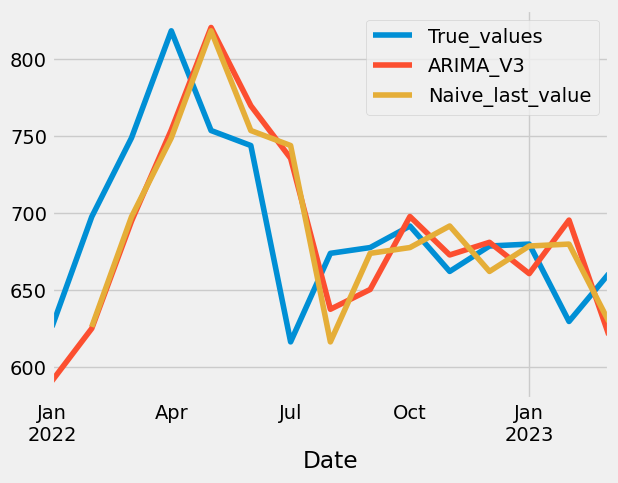

In [37]:
comparative_v3.set_index("Date").plot()

In [38]:
kpis_v3 = get_kpis_summary(comparative_v3['True_values'],comparative_v3['ARIMA_V3'])

### Arima Expanding Window com trasnformação (Mensal) 

In [39]:
test_price_monthly_transformed =  auto_stationary.transform(test_commodity_monthly)

In [40]:
test_price_monthly_transformed

Date
2022-01-31    7.406475
2022-02-28    7.760878
2022-03-31    7.977635
2022-04-30    8.237497
2022-05-31    7.989989
2022-06-30    7.946749
2022-07-31    7.322390
2022-08-31    7.624378
2022-09-30    7.638578
2022-10-31    7.701601
2022-11-30    7.552764
2022-12-31    7.631029
2023-01-31    7.632994
2023-02-28    7.364301
2023-03-31    7.527590
dtype: float64

In [41]:
exp_arima_v2 = get_expanding_arima(train_price_monthly_transformed,test_price_monthly_transformed,print_flags=True)
exp_arima_v2

2022-01-31 00:00:00 forecasted !!!!
Prediction:  7.184983116899034
---------------
2022-02-28 00:00:00 forecasted !!!!
Prediction:  7.3600136239601035
---------------
2022-03-31 00:00:00 forecasted !!!!
Prediction:  7.677463213817426
---------------
2022-04-30 00:00:00 forecasted !!!!
Prediction:  7.9159173706056185
---------------
2022-05-31 00:00:00 forecasted !!!!
Prediction:  8.171932042063496
---------------
2022-06-30 00:00:00 forecasted !!!!
Prediction:  8.02727890447471
---------------
2022-07-31 00:00:00 forecasted !!!!
Prediction:  7.963282347432218
---------------
2022-08-31 00:00:00 forecasted !!!!
Prediction:  7.453343656056843
---------------
2022-09-30 00:00:00 forecasted !!!!
Prediction:  7.589366522929495
---------------
2022-10-31 00:00:00 forecasted !!!!
Prediction:  7.628439276540925
---------------
2022-11-30 00:00:00 forecasted !!!!
Prediction:  7.6865320341017735
---------------
2022-12-31 00:00:00 forecasted !!!!
Prediction:  7.580337118092279
---------------
20

{'parameters': [(0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1),
  (0, 1, 1)],
 'expand_forecasts':          Date  Expanding_ARIMA_pred
 0  2022-01-31              7.184983
 1  2022-02-28              7.360014
 2  2022-03-31              7.677463
 3  2022-04-30              7.915917
 4  2022-05-31              8.171932
 5  2022-06-30              8.027279
 6  2022-07-31              7.963282
 7  2022-08-31              7.453344
 8  2022-09-30              7.589367
 9  2022-10-31              7.628439
 10 2022-11-30              7.686532
 11 2022-12-31              7.580337
 12 2023-01-31              7.620577
 13 2023-02-28              7.630433
 14 2023-03-31              7.419206}

In [42]:
auto_stationary.inverse_transform(exp_arima_v2['expand_forecasts'].set_index("Date")["Expanding_ARIMA_pred"]).reset_index().rename(columns={0:"Expanding_ARIMA_pred"})

,Date,Expanding_ARIMA_pred
0,2022-01-31,588.348290
1,2022-02-28,618.563067
2,2022-03-31,680.470581
3,2022-04-30,734.644554
4,2022-05-31,800.874003
5,2022-06-30,763.687493
6,2022-07-31,748.621951
7,2022-08-31,640.515042
8,2022-09-30,667.539667
9,2022-10-31,676.274404


In [43]:
exp_arima_v2['expand_forecasts'] = auto_stationary.inverse_transform(exp_arima_v2['expand_forecasts'].set_index("Date")["Expanding_ARIMA_pred"]).reset_index().rename(columns={0:"Expanding_ARIMA_pred"})


In [44]:
exp_arima_v2['expand_forecasts']

,Date,Expanding_ARIMA_pred
0,2022-01-31,588.348290
1,2022-02-28,618.563067
2,2022-03-31,680.470581
3,2022-04-30,734.644554
4,2022-05-31,800.874003
5,2022-06-30,763.687493
6,2022-07-31,748.621951
7,2022-08-31,640.515042
8,2022-09-30,667.539667
9,2022-10-31,676.274404


In [45]:
comparative_v4 = test_price_monthly.reset_index().rename(columns={"Adj Close":"True_values"})
comparative_v4['ARIMA_V4'] = exp_arima_v2['expand_forecasts']['Expanding_ARIMA_pred']
comparative_v4['Naive_last_value'] = comparative_v4['True_values'].shift(1)

In [46]:
comparative_v4

,Date,True_values,ARIMA_V4,Naive_last_value
0,2022-01-31,626.00,588.348290,NaN
1,2022-02-28,697.50,618.563067,626.00
2,2022-03-31,748.75,680.470581,697.50
3,2022-04-30,818.25,734.644554,748.75
4,2022-05-31,753.50,800.874003,818.25
5,2022-06-30,743.75,763.687493,753.50
6,2022-07-31,616.25,748.621951,743.75
7,2022-08-31,673.75,640.515042,616.25
8,2022-09-30,677.50,667.539667,673.75
9,2022-10-31,691.50,676.274404,677.50


<AxesSubplot:xlabel='Date'>

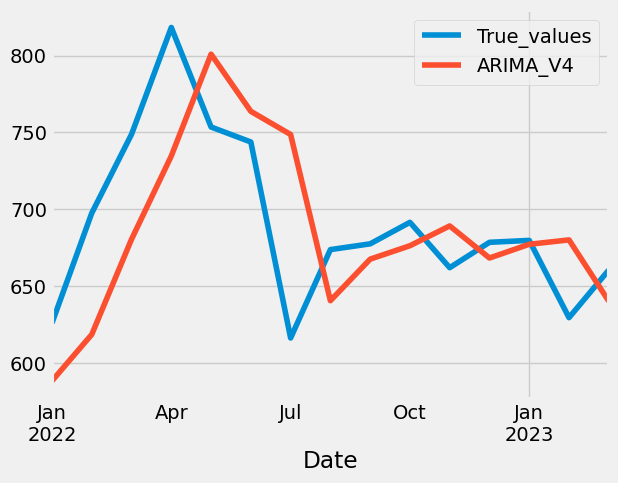

In [47]:
comparative_v4.set_index("Date")[['True_values','ARIMA_V4']].plot()

In [48]:
kpis_v4 = get_kpis_summary(comparative_v4['True_values'],comparative_v4['ARIMA_V4'])

In [49]:
kpis_v4

,KPI,Result
0,MSE,2981.294144
1,RMSE,54.601228
2,MAE,42.491623
3,MASE,0.994787
4,OPE,0.061875
5,MAPE,0.061875
6,EVS,-0.044403
7,Max_err,132.371951
8,Rsquared,-0.055117


-----

## Modelos ANN

In [51]:
def create_lags(df,target_variable='Adj Close',range_lags = [3,6,9,12,24]):
    df_modfic = df.copy()
    for i in range_lags:
        name_col = 'lag'+ str(i)
        df_modfic[name_col] = df_modfic[target_variable].shift(i)

    return df_modfic

def create_diffs(df,target_variable='Adj Close',range_diffs = [3,6,9,12,24]):
    df_modfic = df.copy()
    for i in range_diffs:
        name_col = 'diff'+ str(i)
        df_modfic[name_col] = df_modfic[target_variable].diff(i)

    return df_modfic


def create_rolling_op(df,target_variable='Adj Close',range_window = [3,6,9,12,24],op='mean'):
    df_modfic = df.copy()
    for i in range_window:
        name_col = op + "_" + str(i) 
        df_modfic[name_col] = df_modfic[target_variable].rolling(window=i).agg(op)

    return df_modfic



In [52]:
#criando variaveis 
month_commodity_ann = month_commodity.copy()

alvo = 1

month_commodity_ann['y_target'] = month_commodity_ann['Adj Close'].shift(-alvo) 

month_commodity_ann = create_lags(month_commodity_ann)
month_commodity_ann = create_diffs(month_commodity_ann)

month_commodity_ann = create_rolling_op(month_commodity_ann,op='mean')
month_commodity_ann = create_rolling_op(month_commodity_ann,op='std')

for i in [3,6,9,12,24]:
    name_dist = 'dist_mean_' + str(i)
    name_mean = "mean_" + str(i)
    month_commodity_ann[name_dist] = month_commodity_ann['Adj Close'] - month_commodity_ann[name_mean]


month_commodity_ann = month_commodity_ann.drop("Adj Close",axis=1)
month_commodity_ann = month_commodity_ann.dropna()
month_commodity_ann

,Date,y_target,lag3,lag6,lag9,lag12,lag24,diff3,diff6,diff9,...,std_3,std_6,std_9,std_12,std_24,dist_mean_3,dist_mean_6,dist_mean_9,dist_mean_12,dist_mean_24
24,2004-01-31,296.25,247.25,206.00,232.75,238.25,206.50,29.00,70.25,43.50,...,17.760560,18.614958,19.843310,17.098021,19.467477,20.500000,31.583333,37.722222,38.937500,42.593750
25,2004-02-29,320.00,245.00,233.25,244.25,231.75,200.00,51.25,63.00,52.00,...,25.298633,26.838716,27.723461,23.954058,21.984019,23.416667,41.083333,51.944444,53.562500,58.583333
26,2004-03-31,316.50,246.00,220.25,228.50,236.50,207.00,74.00,99.75,91.50,...,21.901769,31.392442,36.568951,32.571156,26.720880,22.500000,48.208333,65.527778,70.354167,77.625000
27,2004-04-30,304.00,276.25,247.25,206.00,232.75,193.50,40.25,69.25,110.50,...,12.821694,33.240663,36.809476,37.257321,28.664097,5.583333,33.166667,49.750000,59.875000,69.000000
28,2004-05-31,257.50,296.25,245.00,233.25,244.25,214.00,7.75,59.00,70.75,...,8.411302,27.936386,36.312255,39.384967,29.949232,-9.500000,10.833333,29.388889,42.395833,52.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2022-10-31,662.00,616.25,818.25,626.00,568.25,398.50,75.25,-126.75,65.50,...,9.355257,50.475592,58.953106,74.394704,99.457463,10.583333,-1.208333,-21.916667,7.583333,63.156250
250,2022-11-30,678.50,673.75,753.50,697.50,567.00,419.75,-11.75,-91.50,-35.50,...,14.756355,41.451000,61.292389,65.323699,89.123091,-15.000000,-15.458333,-47.472222,-29.833333,23.562500
251,2022-12-31,679.75,677.50,743.75,748.75,593.25,484.00,1.00,-65.25,-70.25,...,14.784564,26.411487,60.127209,57.834022,83.109431,1.166667,11.916667,-23.166667,-20.437500,31.958333
252,2023-01-31,629.50,691.50,616.25,818.25,626.00,547.00,-11.75,63.50,-138.50,...,9.906858,9.546814,41.351475,53.597864,80.575393,6.333333,2.583333,-6.527778,-23.666667,27.677083


In [53]:
corr = month_commodity_ann.query("Date <= '2022-01-01'").drop("Date",axis=1).corr()
target_corr = corr['y_target'].sort_values().reset_index()
target_corr['y_target'] = target_corr['y_target']
target_corr = target_corr.query("index != 'y_target' ")

In [54]:
significant_variables = target_corr[target_corr['y_target'].abs() >= 0.5]['index'].values.tolist()
filter_cols = ['Date','y_target'] + significant_variables

In [55]:
month_commodity_ann[filter_cols]

,Date,y_target,lag12,std_24,dist_mean_24,std_6,diff24,std_12,lag9,std_9,mean_24,lag6,mean_12,lag3,mean_9,mean_6,mean_3
24,2004-01-31,296.25,238.25,19.467477,42.593750,18.614958,69.75,17.098021,232.75,19.843310,233.656250,206.00,237.312500,247.25,238.527778,244.666667,255.750000
25,2004-02-29,320.00,231.75,21.984019,58.583333,26.838716,96.25,23.954058,244.25,27.723461,237.666667,233.25,242.687500,245.00,244.305556,255.166667,272.833333
26,2004-03-31,316.50,236.50,26.720880,77.625000,31.392442,113.00,32.571156,228.50,36.568951,242.375000,220.25,249.645833,246.00,254.472222,271.791667,297.500000
27,2004-04-30,304.00,232.75,28.664097,69.000000,33.240663,123.00,37.257321,206.00,36.809476,247.500000,247.25,256.625000,276.25,266.750000,283.333333,310.916667
28,2004-05-31,257.50,244.25,29.949232,52.750000,27.936386,90.00,39.384967,233.25,36.312255,251.250000,245.00,261.604167,296.25,274.611111,293.166667,313.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2022-10-31,662.00,568.25,99.457463,63.156250,50.475592,293.00,74.394704,626.00,58.953106,628.343750,818.25,683.916667,616.25,713.416667,692.708333,680.916667
250,2022-11-30,678.50,567.00,89.123091,23.562500,41.451000,242.25,65.323699,697.50,61.292389,638.437500,753.50,691.833333,673.75,709.472222,677.458333,677.000000
251,2022-12-31,679.75,593.25,83.109431,31.958333,26.411487,194.50,57.834022,748.75,60.127209,646.541667,743.75,698.937500,677.50,701.666667,666.583333,677.333333
252,2023-01-31,629.50,626.00,80.575393,27.677083,9.546814,132.75,53.597864,818.25,41.351475,652.072917,616.25,703.416667,691.50,686.277778,677.166667,673.416667


In [56]:
train_ANN ,test_ANN = train_test_split(month_commodity_ann[filter_cols],date_column='Date',split='2022-01-01',by_date=True)

Train : start:2004-01-31 00:00:00 ---- end:2021-12-31 00:00:00
Test : start:2022-01-31 00:00:00 ---- end:2023-02-28 00:00:00


In [57]:
X_train_ANN = train_ANN.drop("y_target",axis=1)
y_train_ANN = train_ANN['y_target']

X_test_ANN = test_ANN.drop("y_target",axis=1)
y_test_ANN = test_ANN['y_target']

In [109]:


pipeline = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', MLPRegressor())
])

param_grid = {
       'regressor__hidden_layer_sizes': [(50, 50),(100,100), (50,100,50),(50,100,100,50),(100,300,100),(200,200,200)],
       'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
       'regressor__activation': ['relu', 'tanh'],
       'regressor__solver': ['adam', 'lbfgs'],
       'regressor__max_iter': [100,500, 1000],
}

# param_grid = {
#     'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'regressor__activation': ['relu', 'tanh'],
#     'regressor__alpha': [0.0001, 0.001, 0.01],
# }
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(pipeline,    param_grid, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train_ANN,y_train_ANN)

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess', MinMaxScaler()),
                                       ('regressor', MLPRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__activation': ['relu', 'tanh'],
                         'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'regressor__hidden_layer_sizes': [(50, 50), (100, 100),
                                                           (50, 100, 50),
                                                           (50, 100, 100, 50),
                                                           (100, 300, 100),
                                                           (200, 200, 200)],
                         'regressor__max_iter': [100, 500, 1000],
                         'regressor__solver': ['adam', 'lbfgs']},
             scoring='neg_mean_squared_error')

In [110]:
grid_search.predict(X_test_ANN)

array([639.45968648, 679.264892  , 732.95722222, 795.5778649 ,
       728.10056435, 726.20330291, 632.98964281, 654.81936582,
       651.40995027, 665.90992898, 665.57334982, 691.873934  ,
       687.8081362 , 628.0965271 ])

In [111]:
grid_search.best_params_

{'regressor__activation': 'relu',
 'regressor__alpha': 0.1,
 'regressor__hidden_layer_sizes': (100, 100),
 'regressor__max_iter': 100,
 'regressor__solver': 'lbfgs'}

In [112]:
np.sqrt(-grid_search.best_score_)

72.59106921011407

In [226]:
comparative_v6 = y_test_ANN.reset_index()
comparative_v6

,Date,y_target
0,2022-01-31,697.50
1,2022-02-28,748.75
2,2022-03-31,818.25
3,2022-04-30,753.50
4,2022-05-31,743.75
5,2022-06-30,616.25
6,2022-07-31,673.75
7,2022-08-31,677.50
8,2022-09-30,691.50
9,2022-10-31,662.00


In [227]:
comparative_v6['ANN_tunned'] = grid_search.predict(X_test_ANN)

<AxesSubplot:xlabel='Date'>

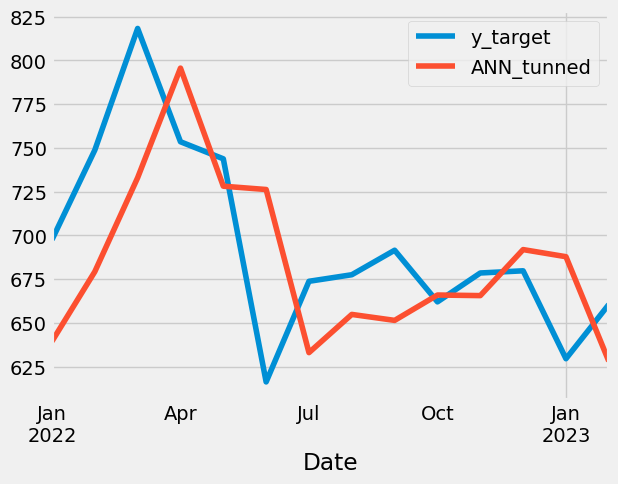

In [228]:
comparative_v6.set_index("Date").plot()

In [116]:
kpis_v6 = get_kpis_summary(comparative_v6['y_target'],comparative_v6['ANN_tunned'])
kpis_v6

,KPI,Result
0,MSE,2724.223280
1,RMSE,52.194092
2,MAE,43.121569
3,MASE,1.064730
4,OPE,0.062285
5,MAPE,0.062285
6,EVS,0.037413
7,Max_err,109.953303
8,Rsquared,-0.005499


# XGBOOST

In [145]:
train_xgboost ,test_xgboost = train_test_split(month_commodity_ann[filter_cols],date_column='Date',split='2022-01-01',by_date=True)

X_train_xgboost = train_xgboost.drop("y_target",axis=1)
y_train_xgboost = train_xgboost['y_target']

X_test_xgboost = test_xgboost.drop("y_target",axis=1)
y_test_xgboost = test_ANN['y_target']

Train : start:2004-01-31 00:00:00 ---- end:2021-12-31 00:00:00
Test : start:2022-01-31 00:00:00 ---- end:2023-02-28 00:00:00


In [146]:
train_xgboost ,test_xgboost = train_test_split(month_commodity_ann[filter_cols],date_column='Date',split='2022-01-01',by_date=True)

Train : start:2004-01-31 00:00:00 ---- end:2021-12-31 00:00:00
Test : start:2022-01-31 00:00:00 ---- end:2023-02-28 00:00:00


In [147]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective = "reg:squarederror",eval_metric='rmse'))
])

param_grid_xgboost = {
    "regressor__colsample_bytree": [0.8] , 
    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [0], 
    "regressor__subsample": [0.8], 
    "regressor__max_depth": [5],
    "regressor__min_child_weight": [5],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_absolute_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )





Fitting 5 folds for each of 1 candidates, totalling 5 fits

Model Report
MAE: 6.734
RMSE: 9.143


**1-) Tunando o max_depth and min_child_weight.**

In [164]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse'))
])

param_grid_xgboost = {
    "regressor__colsample_bytree": [0.8] , 
    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [0], 
    "regressor__subsample": [0.8], 
    "regressor__max_depth": range(3,10,2),
    "regressor__min_child_weight": range(1,6,2),
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Model Report
MAE: 11.88
RMSE: 15.38

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight': 3, 'regressor__subsample': 0.8}

Best GS Score RMSE
115.41601818681028


In [165]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse'))
])

param_grid_xgboost = {
    "regressor__colsample_bytree": [0.8] , 
    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [0], 
    "regressor__subsample": [0.8], 
    "regressor__max_depth": [4,5,6],
    "regressor__min_child_weight": [2,3,4],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Model Report
MAE: 6.579
RMSE: 8.462

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__subsample': 0.8}

Best GS Score RMSE
111.44748719130102


In [179]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse'))
])

param_grid_xgboost = {
    "regressor__colsample_bytree": [0.8] , 
    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [0], 
    "regressor__subsample": [0.8], 
    "regressor__max_depth": [4],
    "regressor__min_child_weight": [3,6,8,10,12],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 5 candidates, totalling 25 fits

Model Report
MAE: 13.51
RMSE: 19

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 12, 'regressor__subsample': 0.8}

Best GS Score RMSE
111.64211294736879


Não melhorou as métricas nos treinos. Melhores resultados:
* max_depth: 4
* min_child_weight: 2

**2-) Tunando o  gama**

In [188]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse'))
])

param_grid_xgboost = {
    "regressor__colsample_bytree": [0.8] , 
    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [i/10.0 for i in range(0,5)], 
    "regressor__subsample": [0.8], 
    "regressor__max_depth": [4],
    "regressor__min_child_weight": [2],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 5 candidates, totalling 25 fits

Model Report
MAE: 6.579
RMSE: 8.462

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__subsample': 0.8}

Best GS Score RMSE
111.4465692555194


aumentando numero de estimadores

In [189]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse',n_estimators=1000))
])

param_grid_xgboost = {
    "regressor__colsample_bytree": [0.8] , 
    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [i/10.0 for i in range(0,5)], 
    "regressor__subsample": [0.8], 
    "regressor__max_depth": [4],
    "regressor__min_child_weight": [2],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 5 candidates, totalling 25 fits

Model Report
MAE: 0.001853
RMSE: 0.002348

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0.0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__subsample': 0.8}

Best GS Score RMSE
110.10879766517218


Observação: melhora na performance
* max_depth: 4
* min_child_weight: 2
* gamma: 0


**3-) Tunning subsample and colsample_bytree**

In [190]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse',n_estimators=1000))
])

param_grid_xgboost = {

    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [0], 
    'regressor__subsample':[i/10.0 for i in range(6,10)],
    'regressor__colsample_bytree':[i/10.0 for i in range(6,10)],
    "regressor__max_depth": [4],
    "regressor__min_child_weight": [2],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Model Report
MAE: 0.001833
RMSE: 0.002345

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__subsample': 0.7}

Best GS Score RMSE
106.83682097265378




* colsample_bytree:0.8
* subsample:0.7

Testar agora aumentando o número de intervalos

In [191]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse',n_estimators=1000))
])

param_grid_xgboost = {

    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [0], 
    'regressor__subsample':[i/100.0 for i in range(75,90,5)],
    'regressor__colsample_bytree':[i/100.0 for i in range(75,90,5)],
    "regressor__max_depth": [4],
    "regressor__min_child_weight": [2],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Model Report
MAE: 0.001778
RMSE: 0.002202

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__subsample': 0.75}

Best GS Score RMSE
106.62603048210553


Observação: sem grandes melhoras na performance

* colsample_bytree: 0.8
* subsample: 0.75



----

**4-) Tunando o parâmetro de regularização**

In [194]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse',n_estimators=1000))
])

param_grid_xgboost = {
    "regressor__reg_alpha": [0, 0.001, 0.005, 0.01, 0.05],
    "regressor__learning_rate": [0.1], 
    "regressor__gamma": [0], 
    'regressor__subsample':[0.75],
    'regressor__colsample_bytree':[0.8],
    "regressor__max_depth": [4],
    "regressor__min_child_weight": [2],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 5 candidates, totalling 25 fits

Model Report
MAE: 0.00232
RMSE: 0.002879

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__reg_alpha': 0.005, 'regressor__subsample': 0.75}

Best GS Score RMSE
106.51379812189019



* regressor__reg_alpha': 0.005

**5-) Tunando a taxa de aprendizado e aumentando número de estimadores**

In [195]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse',n_estimators=5000))
])

param_grid_xgboost = {
    "regressor__reg_alpha": [0.005],
    "regressor__learning_rate": [0.01,0.05,0.1,0.2,0.3], 
    "regressor__gamma": [0], 
    'regressor__subsample':[0.75],
    'regressor__colsample_bytree':[0.8],
    "regressor__max_depth": [4],
    "regressor__min_child_weight": [2],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 5 candidates, totalling 25 fits

Model Report
MAE: 0.0006881
RMSE: 0.0008727

Best GS Params
{'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 2, 'regressor__reg_alpha': 0.005, 'regressor__subsample': 0.75}

Best GS Score RMSE
106.51378523662217



* melhor learning rate: 0.1 


**6-) Juntando tudo**

In [197]:

#Testing wth default parameters

pipeline_xboost = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('regressor', xgb.XGBRegressor(objective =  "reg:squarederror",eval_metric='rmse',n_estimators=5000))
])

param_grid_xgboost = {

    "regressor__learning_rate": [0.01,0.1,0.3], 
    "regressor__gamma": [0,0.2,0.3], 
    'regressor__subsample':[0.7,0.8,0.9],
    'regressor__colsample_bytree':[0.65,0.75,0.85],
    "regressor__max_depth": [4,5,6],
    "regressor__min_child_weight": [2,6,10],
    "regressor__reg_alpha": [0, 0.005, 0.01],
}


tscv = TimeSeriesSplit(n_splits=5)

grid_search_xgboost = GridSearchCV(pipeline_xboost, param_grid_xgboost, 
                           cv=tscv, 
                           n_jobs=-1,
                           scoring='neg_mean_squared_error',verbose=True)

 #Fit the algorithm on the data

grid_search_xgboost.fit(X_train_xgboost,y_train_xgboost)

#Predict training set:
train_predictions = grid_search_xgboost.predict(X_train_xgboost)

    
#Print model report:
print("\nModel Report")
print("MAE: %.4g" % mean_absolute_error(y_train_xgboost, train_predictions ))
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train_xgboost, train_predictions )) )



print("\nBest GS Params")
print(grid_search_xgboost.best_params_ )

print("\nBest GS Score RMSE")
print(np.sqrt(-grid_search_xgboost.best_score_))


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits

Model Report
MAE: 0.1174
RMSE: 0.1457

Best GS Params
{'regressor__colsample_bytree': 0.85, 'regressor__gamma': 0.2, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 2, 'regressor__reg_alpha': 0, 'regressor__subsample': 0.7}

Best GS Score RMSE
105.83007726051021


----

'colsample_bytree': 0.85, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'reg_alpha': 0, 'subsample': 0.7}

<AxesSubplot:xlabel='Date'>

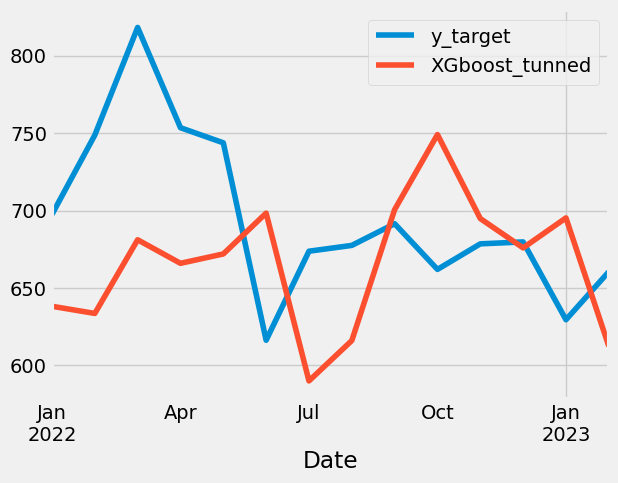

In [198]:
comparative_v7 = y_test_xgboost.reset_index()

comparative_v7['XGboost_tunned'] = grid_search_xgboost.predict(X_test_xgboost)
kpis_v7 = get_kpis_summary(comparative_v7['y_target'],comparative_v7['XGboost_tunned'])
comparative_v7.set_index("Date").plot()

In [199]:
kpis_v7

,KPI,Result
0,MSE,5751.438708
1,RMSE,75.838240
2,MAE,66.319676
3,MASE,1.637523
4,OPE,0.094222
5,MAPE,0.094222
6,EVS,-0.809821
7,Max_err,137.117554
8,Rsquared,-1.122831


-----
# Comparando resultados

In [209]:

arima_comparative = comparative_v3.merge(comparative_v4[['Date','ARIMA_V4']],on='Date',how='left')

In [214]:
arima_comparative = arima_comparative[['Date', 'True_values','Naive_last_value', 'ARIMA_V3',  'ARIMA_V4']]

In [218]:
arima_comparative = arima_comparative.rename(columns={"True_values":"y_true",
                                  'ARIMA_V3':"ARIMA_no_trasnform",
                                  "ARIMA_V4":"ARIMA_with_trasnform"})

In [219]:
arima_comparative 

,Date,y_true,Naive_last_value,ARIMA_no_trasnform,ARIMA_with_trasnform
0,2022-01-31,626.00,NaN,590.900233,588.348290
1,2022-02-28,697.50,626.00,624.948535,618.563067
2,2022-03-31,748.75,697.50,694.688417,680.470581
3,2022-04-30,818.25,748.75,753.884618,734.644554
4,2022-05-31,753.50,818.25,820.429918,800.874003
5,2022-06-30,743.75,753.50,769.607451,763.687493
6,2022-07-31,616.25,743.75,735.441396,748.621951
7,2022-08-31,673.75,616.25,637.432812,640.515042
8,2022-09-30,677.50,673.75,650.290314,667.539667
9,2022-10-31,691.50,677.50,697.649918,676.274404


In [232]:
comparative_v6

,Date,y_target,ANN_tunned
0,2022-01-31,697.50,639.459686
1,2022-02-28,748.75,679.264892
2,2022-03-31,818.25,732.957222
3,2022-04-30,753.50,795.577865
4,2022-05-31,743.75,728.100564
5,2022-06-30,616.25,726.203303
6,2022-07-31,673.75,632.989643
7,2022-08-31,677.50,654.819366
8,2022-09-30,691.50,651.409950
9,2022-10-31,662.00,665.909929


In [233]:
comparative_v7

,Date,y_target,XGboost_tunned
0,2022-01-31,697.50,638.184570
1,2022-02-28,748.75,633.564331
2,2022-03-31,818.25,681.132446
3,2022-04-30,753.50,665.934326
4,2022-05-31,743.75,671.978516
5,2022-06-30,616.25,698.355103
6,2022-07-31,673.75,589.987305
7,2022-08-31,677.50,616.039429
8,2022-09-30,691.50,700.615112
9,2022-10-31,662.00,749.074829


In [236]:
ann_xbgoost =  pd.DataFrame({"Date": arima_comparative['Date'][1:].values,
     "ANN_tunned": comparative_v6['ANN_tunned'].values,
     "XGBoots_tunned": comparative_v7['XGboost_tunned'].values})

In [239]:
selected_comparative = arima_comparative.merge(ann_xbgoost,on='Date',how='left')

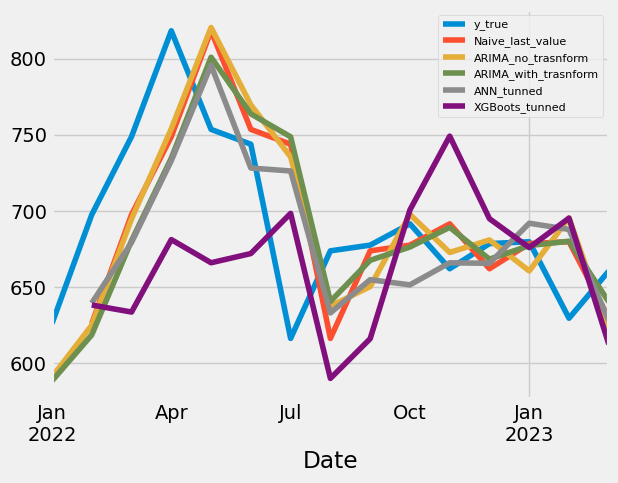

In [275]:
fig, ax = plt.subplots()  # Create a figure and axes

selected_comparative.set_index("Date").plot(ax=ax)  # Plot the DataFrame on the axes

ax.legend(fontsize=8)
plt.show()


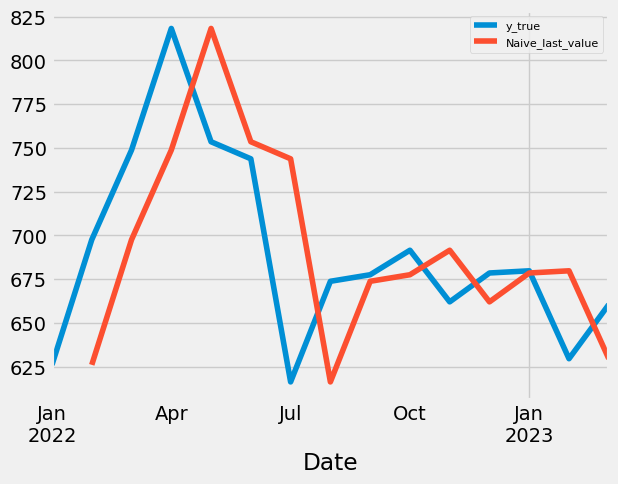

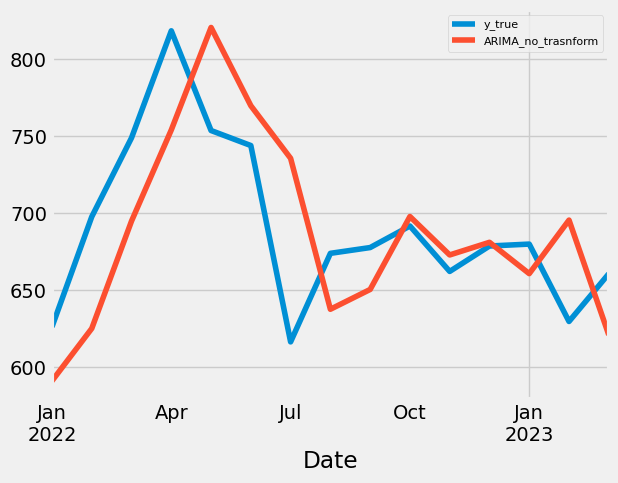

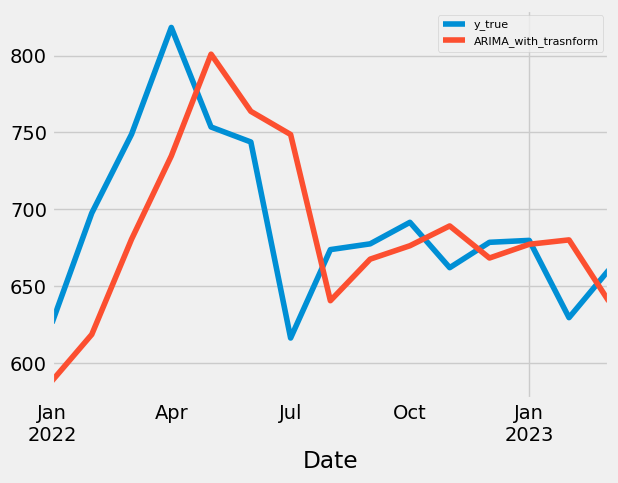

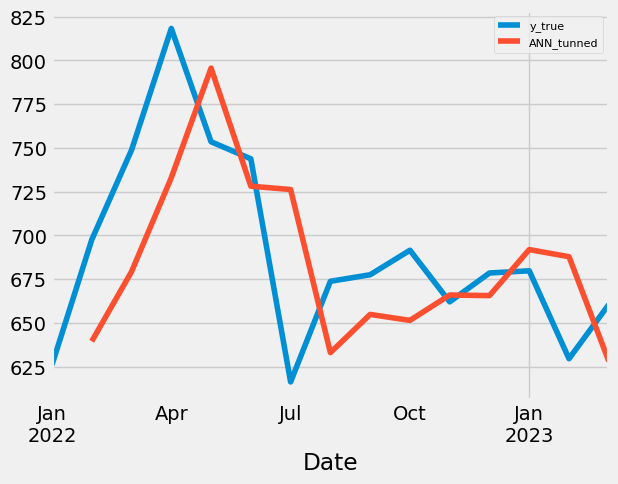

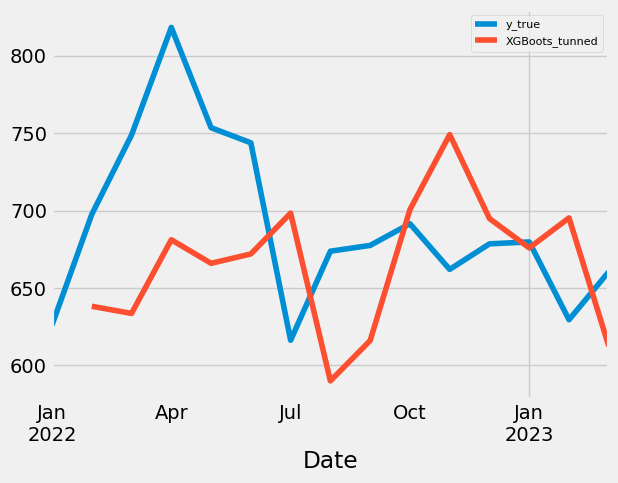

In [278]:
for i in ['Naive_last_value', 'ARIMA_no_trasnform', 'ARIMA_with_trasnform', 'ANN_tunned', 'XGBoots_tunned']:
    fig, ax = plt.subplots()  # Create a figure and axes

    selected_comparative[['Date','y_true',i]].set_index("Date").plot(ax=ax)  # Plot the DataFrame on the axes

    ax.legend(fontsize=8)
    plt.show()


In [249]:
kpis_v3['Model'] = "ARIMA_no_transform"
kpis_v4['Model'] = "ARIMA_with_transform"
kpis_v6['Model'] = "ANN_tunned"
kpis_v7['Model'] = "XGBoost_tunned"

In [260]:
get_kpis_summary()

<function modeling_utils.get_kpis_summary(y_true, y_pred)>

In [261]:
kpi_naive = get_kpis_summary(selected_comparative['y_true'][1:],selected_comparative['Naive_last_value'][1:])

In [263]:
kpi_naive['Model'] = 'Naive_last_value'

In [264]:
list_tabs_KPIs = []
for tab in [kpis_v3,kpis_v4,kpis_v6,kpis_v7,kpi_naive]:
    pivot_tab = tab.pivot_table(columns='KPI',values='Result',index='Model')
    pivot_tab.index.name = None
    pivot_tab.columns.name = None
    pivot_tab.reset_index()
    list_tabs_KPIs.append(pivot_tab)

consolidated_kpis = pd.concat(list_tabs_KPIs)


In [265]:
consolidated_kpis = consolidated_kpis[['MAE','RMSE','MAPE']] 

In [267]:
consolidated_kpis

,MAE,RMSE,MAPE
ARIMA_no_transform,43.038973,52.544682,0.062905
ARIMA_with_transform,42.491623,54.601228,0.061875
ANN_tunned,43.121569,52.194092,0.062285
XGBoost_tunned,66.319676,75.838240,0.094222
Naive_last_value,42.714286,54.287183,0.062174


In [273]:
with pd.ExcelWriter('dados_e_resultados.xlsx') as writer:
    commodity.to_excel(writer,sheet_name='daily_data')
    month_commodity.to_excel(writer,sheet_name='monhtly_data')
    month_commodity_ann.to_excel(writer,sheet_name='monhtly_data_variables')
    selected_comparative.to_excel(writer,sheet_name='predictions_comparative')
    consolidated_kpis.to_excel(writer,sheet_name='kpis')
    